In [1]:
import pandas as pd
import os
import math
import collections
from itertools import groupby

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import entropy
import pickle


from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import re

## Importing the dataset

In [2]:
df = pd.read_csv("sqli_dataset.tsv", sep='\t')
df.dropna(inplace=True)

print("type\t count")

print ("Normal data",df['label'].value_counts()[0])

print ("SQL Injection",df['label'].value_counts()[1])


type	 count
Normal data 23230
SQL Injection 27374


## The dataset before processing

In [3]:
df

,text_body,label
0,"3),)))),',""(",1.0
1,"3)'hRoCZw<'"">gMciSC",1.0
2,3)) AND 3788=5477 AND (1660=1660,1.0
3,3) AND 2729=6903,1.0
4,3)') AND 2478=9182 AND ('wZdR'='wZdR,1.0
...,...,...
50653,"comment6, http://www.ifreakinglovefishing.com/...",0.0
50654,"comment6, http://www.lissycakes.com/mysticism/...",0.0
50655,"comment6, http://www.nataliagallo.com/young-ad...",0.0
50656,"comment6, http://www.organikjoos.com/trivia/pd...",0.0


# Data Preprocessing

## Tokenizing

In [4]:
sql_regex = re.compile("(?P<UNION>UNION\s+(ALL\s+)?SELECT)|(?P<PREFIX>([\'\"\)]|((\'|\"|\)|\d+|\w+)\s))(\|\|\&\&|and|or|as|where|IN\sBOOLEAN\sMODE)(\s|\()(\(?\'?-?\d+\'?(=|LIKE|<|>|<=|>=)\'?-?\d+|\(?[\'\"\\\"]\S+[\'\"\\\"](\s+)?(=|LIKE|<|>|<=|>=)(\s+)?[\'\"\\\"]))|(?P<USUAL>([\'\"]\s*)(\|\||\&\&|and|or)(\s*[\'\"])(\s*[\'\"])=)|(?P<DROP>;\s*DROP\s+(TABLE|DATABASE)\s(IF\s+EXISTS\s)?\S+)|(?P<NOTIN>\snot\sin\s?\((\d+|(\'|\")\w+(\'|\"))\))|(?P<LIMIT>LIMIT\s+\d+(\s+)?,(\s+)?\d+)|GROUP_CONCAT\((?P<GRPCONCAT>.*?)\)|(?P<ORDERBY>ORDER\s+BY\s+\d+)|CONCAT\((?P<CONCAT>.*?)\)|(?P<CASEWHEN>\(CASE\s(\d+\s|\(\d+=\d+\)\s|NULL\s)?WHEN\s(\d+|\(?\d+=\d+\)?|NULL)\sTHEN\s(\d+|\(\d+=\d+\)|NULL)\sELSE)|(?P<DBNAME>(?:(?:m(?:s(?:ysaccessobjects|ysaces|ysobjects|ysqueries|ysrelationships|ysaccessstorage|ysaccessxml|ysmodules|ysmodules2|db)|aster\.\.sysdatabases|ysql\.db)|s(?:ys(?:\.database_name|aux)|chema(?:\W*\(|_name)|qlite(_temp)?_master)|d(?:atabas|b_nam)e\W*\(|information_schema|pg_(catalog|toast)|northwind|tempdb)))|(?P<DATABASE>DATABASE\(\))|(?P<DTCNAME>table_name|column_name|table_schema|schema_name)|(?P<CAST>CAST\(.*AS\s+\w+\))|(?P<INQUERY>\(SELECT[^a-z_0-9])|(?P<CHRBYPASS>((CHA?R\(\d+\)(,|\|\||\+)\s?)+)|CHA?R\((\d+,\s?)+\))|(?P<FROMDB>\sfrom\s(dual|sysmaster|sysibm)[\s.:])|(?P<MYSQLFUNC>[^.](ABS|ACOS|ADDDATE|ADDTIME|AES_DECRYPT|AES_ENCRYPT|ANY_VALUE|ASCII|ASIN|ASYMMETRIC_DECRYPT|ASYMMETRIC_DERIVE|ASYMMETRIC_ENCRYPT|ASYMMETRIC_SIGN|ASYMMETRIC_VERIFY|ATAN|ATAN2|AVG|BENCHMARK|BIN|BIT_AND|BIT_COUNT|BIT_LENGTH|BIT_OR|BIT_XOR|CAST|CEIL|CEILING|CHAR|CHAR_LENGTH|CHARACTER_LENGTH|CHARSET|COALESCE|COERCIBILITY|COLLATION|COMPRESS|CONCAT|CONCAT_WS|CONNECTION_ID|CONV|CONVERT|CONVERT_TZ|COS|COT|COUNT|COUNT|CRC32|CREATE_ASYMMETRIC_PRIV_KEY|CREATE_ASYMMETRIC_PUB_KEY|CREATE_DH_PARAMETERS|CREATE_DIGEST|CURDATE|CURRENT_DATE|CURRENT_TIME|CURRENT_TIMESTAMP|CURRENT_USER|CURTIME|DATABASE|DATE|DATE_ADD|DATE_FORMAT|DATE_SUB|DATEDIFF|DAY|DAYNAME|DAYOFMONTH|DAYOFWEEK|DAYOFYEAR|DECODE|DEFAULT|DEGREES|ELT|ENCODE|EXP|EXPORT_SET|EXTRACT|EXTRACTVALUE|FIELD|FIND_IN_SET|FLOOR|FORMAT|FOUND_ROWS|FROM_BASE64|FROM_DAYS|FROM_UNIXTIME|GeometryCollection|GET_FORMAT|GET_LOCK|GREATEST|GROUP_CONCAT|GTID_SUBSET|GTID_SUBTRACT|HEX|HOUR|IF|IFNULL|IIF|IN|INET_ATON|INET_NTOA|INET6_ATON|INET6_NTOA|INSERT|INSTR|INTERVAL|IS_FREE_LOCK|IS_IPV4|IS_IPV4_COMPAT|IS_IPV4_MAPPED|IS_IPV6|IS_USED_LOCK|ISNULL|JSON_APPEND|JSON_ARRAY|JSON_ARRAY_APPEND|JSON_ARRAY_INSERT|JSON_CONTAINS|JSON_CONTAINS_PATH|JSON_DEPTH|JSON_EXTRACT|JSON_INSERT|JSON_KEYS|JSON_LENGTH|JSON_MERGE|JSON_OBJECT|JSON_QUOTE|JSON_REMOVE|JSON_REPLACE|JSON_SEARCH|JSON_SET|JSON_TYPE|JSON_UNQUOTE|JSON_VALID|LAST_INSERT_ID|LCASE|LEAST|LEFT|LENGTH|LineString|LN|LOAD_FILE|LOCALTIME|LOCALTIMESTAMP|LOCATE|LOG|LOG10|LOG2|LOWER|LPAD|LTRIM|MAKE_SET|MAKEDATE|MAKETIME|MASTER_POS_WAIT|MAX|MBRContains|MBRCoveredBy|MBRCovers|MBRDisjoint|MBREquals|MBRIntersects|MBROverlaps|MBRTouches|MBRWithin|MICROSECOND|MID|MIN|MINUTE|MOD|MONTH|MONTHNAME|MultiLineString|MultiPoint|MultiPolygon|NAME_CONST|NOT IN|NOW|NULLIF|OCT|OCTET_LENGTH|OLD_PASSWORD|ORD|PERIOD_ADD|PERIOD_DIFF|PI|Point|Polygon|POSITION|POW|POWER|PROCEDURE ANALYSE|QUARTER|QUOTE|RADIANS|RAND|RANDOM_BYTES|RELEASE_ALL_LOCKS|RELEASE_LOCK|REPEAT|REPLACE|REVERSE|RIGHT|ROUND|ROW_COUNT|RPAD|RTRIM|SCHEMA|SEC_TO_TIME|SECOND|SESSION_USER|SHA1|SHA2|SIGN|SIN|SLEEP|SOUNDEX|SPACE|SQRT|ST_Area|ST_AsBinary|ST_AsGeoJSON|ST_AsText|ST_Buffer|ST_Buffer_Strategy|ST_Centroid|ST_Contains|ST_ConvexHull|ST_Crosses|ST_Difference|ST_Dimension|ST_Disjoint|ST_Distance|ST_Distance_Sphere|ST_EndPoint|ST_Envelope|ST_Equals|ST_ExteriorRing|ST_GeoHash|ST_GeomCollFromText|ST_GeomCollFromWKB|ST_GeometryN|ST_GeometryType|ST_GeomFromGeoJSON|ST_GeomFromText|ST_GeomFromWKB|ST_InteriorRingN|ST_Intersection|ST_Intersects|ST_IsClosed|ST_IsEmpty|ST_IsSimple|ST_IsValid|ST_LatFromGeoHash|ST_Length|ST_LineFromText|ST_LineFromWKB|ST_LongFromGeoHash|ST_MakeEnvelope|ST_MLineFromText|ST_MLineFromWKB|ST_MPointFromText|ST_MPointFromWKB|ST_MPolyFromText|ST_MPolyFromWKB|ST_NumGeometries|ST_NumInteriorRing|ST_NumPoints|ST_Overlaps|ST_PointFromGeoHash|ST_PointFromText|ST_PointFromWKB|ST_PointN|ST_PolyFromText|ST_PolyFromWKB|ST_Simplify|ST_SRID|ST_StartPoint|ST_SymDifference|ST_Touches|ST_Union|ST_Validate|ST_Within|ST_X|ST_Y|StartPoint|STD|STDDEV|STDDEV_POP|STDDEV_SAMP|STR_TO_DATE|STRCMP|SUBDATE|SUBSTR|SUBSTRING|SUBSTRING_INDEX|SUBTIME|SUM|SYSDATE|SYSTEM_USER|TAN|TIME|TIME_FORMAT|TIME_TO_SEC|TIMEDIFF|TIMESTAMP|TIMESTAMPADD|TIMESTAMPDIFF|TO_BASE64|TO_DAYS|TO_SECONDS|TRIM|TRUNCATE|UCASE|UNCOMPRESS|UNCOMPRESSED_LENGTH|UNHEX|UNIX_TIMESTAMP|UpdateXML|UPPER|USER|UTC_DATE|UTC_TIME|UTC_TIMESTAMP|UUID|UUID_SHORT|VALIDATE_PASSWORD_STRENGTH|VALUES|VAR_POP|VAR_SAMP|VARIANCE|VERSION|WAIT_FOR_EXECUTED_GTID_SET|WAIT_UNTIL_SQL_THREAD_AFTER_GTIDS|WEEK|WEEKDAY|WEEKOFYEAR|WEIGHT_STRING|YEAR|YEARWEEK)\()|(?P<BOOLEAN>\'?-?\d+\'?(=|LIKE)\'?-?\d+($|\s|\)|,|--|#)|[\'\"\\\"]\S+[\'\"\\\"](\s+)?(=|LIKE)(\s+)?[\'\"\\\"]\S+)|(?P<PLAIN>(@|##|#)[A-Z]\w+|[A-Z]\w*(?=\s*\.)|(?<=\.)[A-Z]\w*|[A-Z]\w*(?=\()|`(``|[^`])*`|´(´´|[^´])*´|[_A-Z][_$#\w]*|[가-힣]+)", re.IGNORECASE)

def Sql_tokenizer(raw_sql):
    if sql_regex.search(raw_sql):
        return [tok[0] for tok in groupby([match.lastgroup for match in sql_regex.finditer(raw_sql)])]
    else:
        return ['PLAIN']
        

## Token manipulation

In [5]:
def GetTokenSeq(token_list, N):
    token_seq = []
    for n in range(0,N):
        token_seq += zip(*(token_list[i:] for i in range(n+1)))
    return [str(tuple) for tuple in token_seq]

## Computing the data entropy

In [6]:
def Entropy(input):
    p, lns = collections.Counter(str(input)), float(len(str(input)))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

## Computing the G score

In [7]:
def G_test_score(count, expected):
        if (count == 0):
            return 0
        else:
            return 2.0 * count * math.log(count/expected)

def G_test(tokens, types):
    tokens_cnt = tokens.value_counts().astype(float)
    types_cnt = types.value_counts().astype(float)
    total_cnt = float(sum(tokens_cnt))

    token_cnt_table = collections.defaultdict(lambda : collections.Counter())
    for _tokens, _types in zip(tokens.values, types.values):
        token_cnt_table[_tokens][_types] += 1
  
        datax = []

    tc_dataframe = pd.DataFrame(list(token_cnt_table.values()), index=token_cnt_table.keys())
    tc_dataframe.fillna(0, inplace=True)

    for column in tc_dataframe.columns.tolist():

        if column == 0:
            root_name = "plain"
        else:
            root_name = 'sqli'
        tc_dataframe[root_name+'_exp'] = (tokens_cnt / total_cnt) * types_cnt[column]
        tc_dataframe[root_name+'_GTest'] = [G_test_score(tkn_count, exp) for tkn_count, exp in zip(tc_dataframe[column], tc_dataframe[root_name+'_exp'])]

    return tc_dataframe

def G_means(token_seq, c_name):
    try:
        g_scores = [tc_dataframe.loc[token][c_name] for token in token_seq]
    except KeyError:
        return 0
    return sum(g_scores)/len(g_scores) if g_scores else 0


In [8]:
df['tokenized_body'] = df['text_body'].map(lambda x: Sql_tokenizer(x))

In [9]:
df['token_seq'] = df['tokenized_body'].map(lambda x: GetTokenSeq(x, 3))

In [10]:
_tokens, _types = zip(*[(token,token_type) for token_list,token_type in zip(df['token_seq'], df['label']) for token in token_list])
tc_dataframe = G_test(pd.Series(_tokens), pd.Series(_types))

In [11]:
df['token_length'] = df['tokenized_body'].map(lambda x: len(x))
df['entropy'] = df['text_body'].map(lambda x: Entropy(x))
df['sqli_g_means'] = df['token_seq'].map(lambda x: G_means(x, 'sqli_GTest'))
df['plain_g_means'] = df['token_seq'].map(lambda x: G_means(x, 'plain_GTest'))

df_copy = df

## Dataset with extracted features

In [12]:
df_copy

,text_body,label,tokenized_body,token_seq,token_length,entropy,sqli_g_means,plain_g_means
0,"3),)))),',""(",1.0,[PLAIN],"[('PLAIN',)]",1,2.221252,-29130.153051,56456.194924
1,"3)'hRoCZw<'"">gMciSC",1.0,[PLAIN],"[('PLAIN',)]",1,4.037401,-29130.153051,56456.194924
2,3)) AND 3788=5477 AND (1660=1660,1.0,"[PREFIX, PLAIN, BOOLEAN]","[('PREFIX',), ('PLAIN',), ('BOOLEAN',), ('PREF...",3,3.788910,-4355.690524,9402.085729
3,3) AND 2729=6903,1.0,[PREFIX],"[('PREFIX',)]",1,3.500000,524.979444,0.000000
4,3)') AND 2478=9182 AND ('wZdR'='wZdR,1.0,"[PREFIX, PLAIN, BOOLEAN]","[('PREFIX',), ('PLAIN',), ('BOOLEAN',), ('PREF...",3,4.114369,-4355.690524,9402.085729
...,...,...,...,...,...,...,...,...
50653,"comment6, http://www.ifreakinglovefishing.com/...",0.0,[PLAIN],"[('PLAIN',)]",1,5.064198,-29130.153051,56456.194924
50654,"comment6, http://www.lissycakes.com/mysticism/...",0.0,[PLAIN],"[('PLAIN',)]",1,5.062602,-29130.153051,56456.194924
50655,"comment6, http://www.nataliagallo.com/young-ad...",0.0,[PLAIN],"[('PLAIN',)]",1,5.157021,-29130.153051,56456.194924
50656,"comment6, http://www.organikjoos.com/trivia/pd...",0.0,[PLAIN],"[('PLAIN',)]",1,5.148742,-29130.153051,56456.194924


In [13]:
df = df.iloc[:,4:]

In [14]:
df

,token_length,entropy,sqli_g_means,plain_g_means
0,1,2.221252,-29130.153051,56456.194924
1,1,4.037401,-29130.153051,56456.194924
2,3,3.788910,-4355.690524,9402.085729
3,1,3.500000,524.979444,0.000000
4,3,4.114369,-4355.690524,9402.085729
...,...,...,...,...
50653,1,5.064198,-29130.153051,56456.194924
50654,1,5.062602,-29130.153051,56456.194924
50655,1,5.157021,-29130.153051,56456.194924
50656,1,5.148742,-29130.153051,56456.194924


In [15]:
X = df
y = (df_copy['label'].tolist())

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# Trying out different algorithms

## GradientBoostingClassifier

In [17]:
gb_classifier = GradientBoostingClassifier(learning_rate=1.0, max_depth=10, random_state=0)
gb_classifier.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=10, random_state=0)

In [18]:
y_pred = gb_classifier.predict(X_test)
print(f"Accuracy of Gradient Boosting Classifier on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of Gradient Boosting Classifier on test set : {f1_score(y_pred, y_test)}")

Accuracy of Gradient Boosting Classifier on test set : 0.9519810295425353
F1 Score of Gradient Boosting Classifier on test set : 0.9556245434623813


In [19]:
cm = confusion_matrix(y_test, y_pred)

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

In [20]:
sensitivity = TP / float(FN + TP)
print("Sensitivity:",sensitivity)
specificity = TN / (TN + FP)
print("Specificity:",specificity)
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
print ("Precision:",precision)

Sensitivity: 0.9649640420431496
Specificity: 0.9369944657300979
Precision: 0.9464640983903057


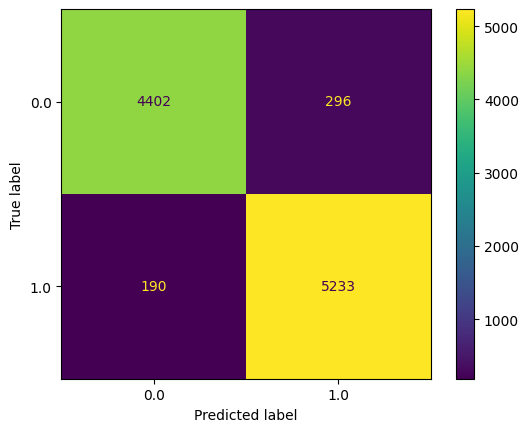

In [21]:
ConfusionMatrixDisplay(cm,display_labels=gb_classifier.classes_).plot()

## SVM

In [22]:
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)

SVC()

In [23]:
y_pred = svc_classifier.predict(X_test)
print(f"Accuracy of SVC on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of SVC on test set : {f1_score(y_pred, y_test)}")

Accuracy of SVC on test set : 0.786681157988341
F1 Score of SVC on test set : 0.7573884706146758


In [24]:
cm = confusion_matrix(y_test, y_pred)

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

In [25]:
sensitivity = TP / float(FN + TP)
print("Sensitivity:",sensitivity)
specificity = TN / (TN + FP)
print("Specificity:",specificity)
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
print ("Precision:",precision)

Sensitivity: 0.6214272542872948
Specificity: 0.9774372073222648
Precision: 0.9695051783659379


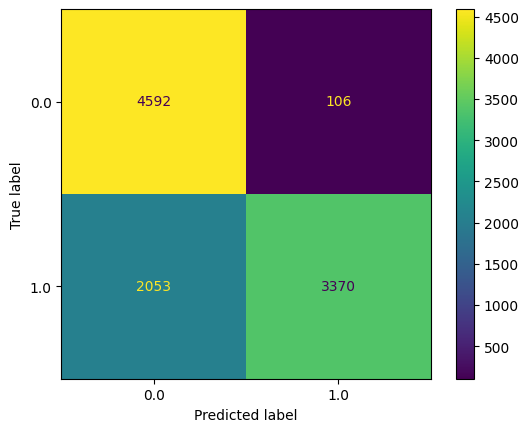

In [26]:
ConfusionMatrixDisplay(cm,display_labels=svc_classifier.classes_).plot()

## Naive Bayes

In [27]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [28]:
y_pred = nb_classifier.predict(X_test)
print(f"Accuracy of NB on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of NB on test set : {f1_score(y_pred, y_test)}")

Accuracy of NB on test set : 0.786681157988341
F1 Score of NB on test set : 0.7573884706146758


In [29]:
cm = confusion_matrix(y_test, y_pred)

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

In [30]:
sensitivity = TP / float(FN + TP)
print("Sensitivity:",sensitivity)
specificity = TN / (TN + FP)
print("Specificity:",specificity)
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
print ("Precision:",precision)

Sensitivity: 0.6214272542872948
Specificity: 0.9774372073222648
Precision: 0.9695051783659379


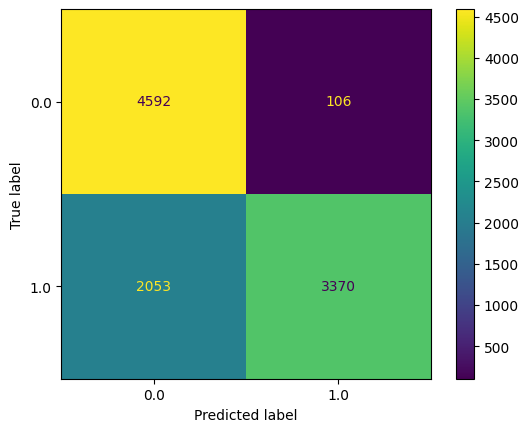

In [31]:
ConfusionMatrixDisplay(cm,display_labels=nb_classifier.classes_).plot()

## Random Forest

In [32]:
rf_classifier =  RandomForestClassifier(n_estimators=100, max_depth=7, random_state=0)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=0)

In [33]:
y_pred = svc_classifier.predict(X_test)
print(f"Accuracy of RF on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of RF on test set : {f1_score(y_pred, y_test)}")

Accuracy of RF on test set : 0.786681157988341
F1 Score of RF on test set : 0.7573884706146758


In [34]:
cm = confusion_matrix(y_test, y_pred)

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

In [35]:
sensitivity = TP / float(FN + TP)
print("Sensitivity:",sensitivity)
specificity = TN / (TN + FP)
print("Specificity:",specificity)
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
print ("Precision:",precision)

Sensitivity: 0.6214272542872948
Specificity: 0.9774372073222648
Precision: 0.9695051783659379


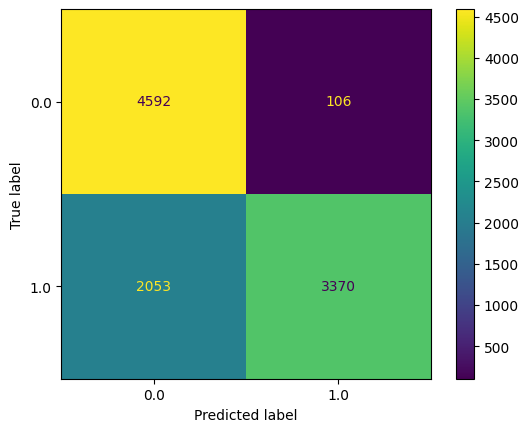

In [36]:
ConfusionMatrixDisplay(cm,display_labels=rf_classifier.classes_).plot()

# Saving the best performing model

In [37]:
# save the model to disk
model_filename = 'sqli_model.h5'

pickle.dump(gb_classifier, open(model_filename, 'wb'))

## Testing the chosen model

In [38]:
def process_input_for_classification(input):
    cleared_input = re.sub(r'(/\*[\w\d(\`|\~|\!|\@|\#|\$|\%|\^|\&|\*|\(|\)|\-|\_|\=|\+|\[|\{|\]|\}|\\|\:|\;|\'|\"|\<|\>|\,|\.|\?)\s\r\n\v\f]*\*/|\*/|/\*!\d+)', ' ', input)

    sql_tokens = Sql_tokenizer(cleared_input.strip())
    token_seq = GetTokenSeq(sql_tokens, 3)
    sqli_g_means = G_means(token_seq, 'sqli_GTest')
    plain_g_means = G_means(token_seq, 'plain_GTest')
    _X = [[len(sql_tokens), Entropy(input), sqli_g_means, plain_g_means]]
    return _X
	

In [39]:
# load the model from disk
loaded_model = pickle.load(open(model_filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print("Accuracy: ",result)

Accuracy:  0.9519810295425353


In [40]:
user_input="1'  )   union all select null"
vectorized_input = process_input_for_classification(user_input)
predictions=loaded_model.predict(vectorized_input)

res = predictions[0]
if res == 1:
    print("SQL INJECTION")
else:
    print("Normal string")

SQL INJECTION


C:\Users\MIPS\Documents\sql_injection_code\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [41]:
user_input="3%29%20UNION%20ALL%20SELECT%20NULL%2CNULL%2CNULL--%20-&type=json"
vectorized_input = process_input_for_classification(user_input)
predictions=loaded_model.predict(vectorized_input)

res = predictions[0]
if res == 1:
    print("SQL INJECTION")
else:
    print("Normal string")

SQL INJECTION


C:\Users\MIPS\Documents\sql_injection_code\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [42]:
user_input="/"
vectorized_input = process_input_for_classification(user_input)
predictions=loaded_model.predict(vectorized_input)

res = predictions[0]
if res == 1:
    print("SQL INJECTION")
else:
    print("Normal string")

Normal string


C:\Users\MIPS\Documents\sql_injection_code\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [43]:
user_input="posts/pseudopost-8/images/metro.jpeg"
vectorized_input = process_input_for_classification(user_input)
predictions=loaded_model.predict(vectorized_input)

res = predictions[0]
if res == 1:
    print("SQL INJECTION")
else:
    print("Normal string")

Normal string


C:\Users\MIPS\Documents\sql_injection_code\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [44]:
user_input="I would like to select the option.. the union is against overspending, or lack of transparency and other stuff like that"
vectorized_input = process_input_for_classification(user_input)
predictions=loaded_model.predict(vectorized_input)

res = predictions[0]
if res == 1:
    print("SQL INJECTION")
else:
    print("Normal string")

Normal string


C:\Users\MIPS\Documents\sql_injection_code\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
